In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Open dataset

In [54]:
case = 'SC-HF-NI-36'

series = json.load(open('series_case.json')) 
image_path_base = './Data/challenge_training/%s/IM-%s' % (case, series[case])
contour_path_base = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
contours_list = glob.glob(contour_path_base + '*')
contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]

In [55]:
def get_roi(image, contour):
    X_min, Y_min = contour[:,0].min(), contour[:,1].min()
    X_max, Y_max = contour[:,0].max(), contour[:,1].max()  
    w = X_max - X_min
    h = Y_max - Y_min
    mask_roi = np.zeros(image.shape)
    if w > h :
        mask_roi[int(Y_min - (w -h)/2):int(Y_max + (w -h)/2), int(X_min):int(X_max)] = 1.0
    else :
        mask_roi[int(Y_min):int(Y_max), int(X_min - (h-w)/2):int(X_max + (h -w)/2)] = 1.0
    return cv2.resize(mask_roi, (32, 32), interpolation = cv2.INTER_NEAREST)

In [56]:
series = json.load(open('series_case.json')) 
images, images_fullsize, contours = [], [], []
for case, serie in series.items():
    image_path_base = './Data/challenge_training/%s/IM-%s' % (case, serie)
    contour_path_base = './Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
    contours_list = glob.glob(contour_path_base + '*')
    contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
    for c in contours_list_series:
        # Get contours and images path
        idx_contour = contours_list_series.index(c)
        image_path = image_path_base + '-%s.dcm' % c
        contour_path = contours_list[idx_contour]

        # open image as numpy array and resize to (64, 64)
        image_part = dicom.read_file(image_path).pixel_array  

        # open contours as numpy array
        contour = []
        file = open(contour_path, 'r') 
        for line in file: 
            contour.append(tuple(map(float, line.split())))
        contour = np.array(contour)
        contours.append(get_roi(image_part, contour))

        images.append(cv2.resize(image_part, (64, 64)))
        images_fullsize.append(cv2.resize(image_part, (256, 256)))

X_fullsize = np.array(images_fullsize)
X = np.reshape(np.array(images), [len(images), 64, 64, 1])
Y = np.reshape(np.array(contours), [len(contours), 1, 32, 32])
print('Dataset shape :', X.shape, Y.shape)

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


In [53]:
images, contours = [], []
for c in contours_list_series:
    # Get contours and images path
    idx_contour = contours_list_series.index(c)
    image_path = image_path_base + '-%s.dcm' % c
    contour_path = contours_list[idx_contour]
    
    # open image as numpy array and resize to (64, 64)
    image_part = dicom.read_file(image_path).pixel_array  
    
    # open contours as numpy array
    contour = []
    file = open(contour_path, 'r') 
    for line in file: 
        contour.append(tuple(map(float, line.split())))
    contour = np.array(contour)
    contours.append(get_roi(image_part, contour))
    
    images.append(cv2.resize(image_part, (64, 64)))
    
X = np.reshape(np.array(images), [len(images), 64, 64, 1])
Y = np.reshape(np.array(contours), [len(contours), 1, 32, 32])
print('Dataset shape :', X.shape, Y.shape)

Dataset shape : (33, 64, 64, 1) (33, 1, 32, 32)


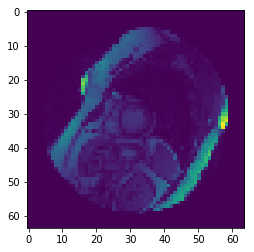

In [57]:
plt.imshow(X[30].reshape(64,64))

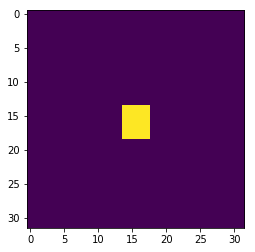

In [58]:
plt.imshow(Y[30].reshape(32, 32))

## Create model

### Without data augmentation

In [59]:
def create_model(input_shape=(64, 64)):
    """
    Simple convnet model
    """
    model = Sequential()
    model.add(Conv2D(100, (11,11), padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

In [60]:
m = create_model()
for p in m.layers:
    print(p.name, p.input_shape, p.output_shape)

conv2d_2 (None, 64, 64, 1) (None, 54, 54, 100)
average_pooling2d_2 (None, 54, 54, 100) (None, 9, 9, 100)
reshape_3 (None, 9, 9, 100) (None, 1, 8100)
dense_2 (None, 1, 8100) (None, 1, 1024)
reshape_4 (None, 1, 1024) (None, 1, 32, 32)


In [61]:
m.compile(loss='mean_squared_error',
          optimizer='adam',
          metrics=['accuracy'])

In [62]:
h = m.fit(X, Y, batch_size=16, epochs=50)

Epoch 1/50
495/495 [==============================] - 5s 10ms/step - loss: 0.1913 - acc: 0.2059
Epoch 2/50
495/495 [==============================] - 4s 8ms/step - loss: 0.1118 - acc: 0.1483
Epoch 3/50
495/495 [==============================] - 5s 9ms/step - loss: 0.0832 - acc: 0.0617
Epoch 4/50
495/495 [==============================] - 4s 9ms/step - loss: 0.0660 - acc: 0.0497
Epoch 5/50
495/495 [==============================] - 4s 8ms/step - loss: 0.0553 - acc: 0.0455
Epoch 6/50
495/495 [==============================] - 4s 9ms/step - loss: 0.0481 - acc: 0.0396
Epoch 7/50
495/495 [==============================] - 5s 10ms/step - loss: 0.0421 - acc: 0.0277
Epoch 8/50
495/495 [==============================] - 5s 9ms/step - loss: 0.0386 - acc: 0.0359
Epoch 9/50
495/495 [==============================] - 5s 10ms/step - loss: 0.0354 - acc: 0.0373
Epoch 10/50
495/495 [==============================] - 5s 10ms/step - loss: 0.0344 - acc: 0.0376: 2s - loss: 0.0344 
Epoch 11/50
495/495 [====

Text(0.5,0,'epochs')

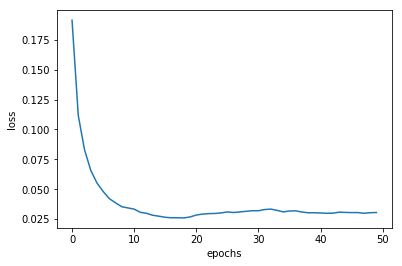

In [63]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [102]:
y_pred = m.predict(X, batch_size=16)

In [133]:
j = 16
# select one predicted ROI
pred = y_pred[j].reshape((32,32))
# select the non null pixels
pos_pred = np.where(pred > 0.5)
# create ROI from non null pixels (pos pred: not a square)
mask_roi = get_roi(pred, np.array(t).reshape(len(t[0]), 2))
# resize ROI to the original MR size
mask_roi = cv2.resize(mask_roi, (256, 256), interpolation = cv2.INTERSECT_FULL)

(107, 108)


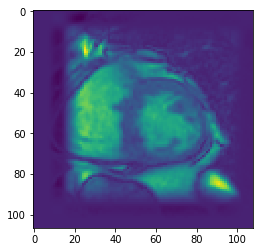

In [134]:
# select the non null pixel to crop a ROI from original image
pos_im = np.where(X_fullsize[j] * mask_roi > 0.5)
contour2 = np.array(pos_im).reshape(len(pos_im[0]), 2)
# select the correct square from the ROI
Xmin, Xmax = contour2[:, 0].min(), contour2[:, 0].max()
Ymin, Ymax = contour2[:, 1].min(), contour2[:, 1].max()
print((X_fullsize[j] * mask_roi)[Xmin:Xmax, Ymin:Ymax].shape)
plt.imshow((X_fullsize[j] * mask_roi)[Xmin:Xmax, Ymin:Ymax])

### With data augmentation

In [373]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False) 
datagen.fit(X)
history = m.fit_generator(datagen.flow(X, Y,
                            batch_size=10),
                            steps_per_epoch=X.shape[0] // 10,
                            epochs=16)  

/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (495, 64, 64, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/16
49/49 [==============================] - 7s - loss: 0.0395 - acc: 0.0370     
Epoch 2/16
49/49 [==============================] - 7s - loss: 0.0388 - acc: 0.0528     
Epoch 3/16
49/49 [==============================] - 7s - loss: 0.0358 - acc: 0.0507     
Epoch 4/16
49/49 [==============================] - 7s - loss: 0.0334 - acc: 0.0566     
Epoch 5/16
49/49 [==============================] - 7s - loss: 0.0328 - acc: 0.0680     
Epoch 6/16
49/49 [==============================] - 8s - loss: 0.0321 - acc: 0.0626     
Epoch 7/16
49/49 [==============================] - 8s - loss: 0.0319 - acc: 0.0622     
Epoch 8/16
49/49 [==============================] - 8s - loss: 0.0298 - acc: 0.0614     
Epoch 9/16
49/49 [==============================] - 8s - loss: 0.0294 - acc: 0.0517     
Epoch 10/16
49/49 [==============================] - 8s - loss: 0.0295 - acc: 0.0652     
Epoch 11/16
49/49 [==============================] - 8s - loss: 0.0294 - acc: 0.0694     
Epoch 12/16
49/49 [

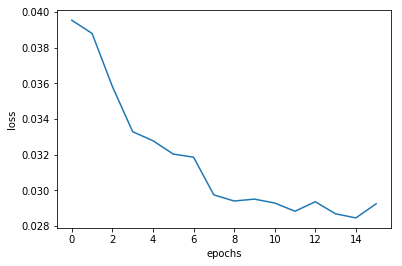

In [375]:
metric = 'loss'
plt.plot(range(len(history.history[metric])), history.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [377]:
y_pred = m.predict(X, batch_size=16)

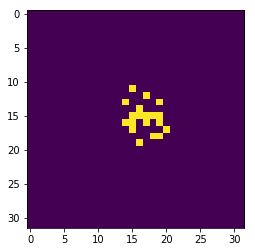

In [378]:
plt.imshow(y_pred[2].reshape(32,32))

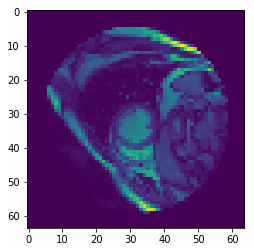

In [367]:
plt.imshow(X[2].reshape(64,64))